# Chapter 5: Supervised learning

This is the notebook companion to chapter 7. We use data from the Lending Club to develop our understanding of machine learning concepts. The Lending Club is a peer-to-peer lending company. It offers loans which are funded by other people. In this sense, the Lending Club acts as a hub connecting borrowers with investors. The client applies for a loan of a certain amount, and the company assesses the risk of the operation. If the application is accepted, it may or may not be fully covered. We will focus on the prediction of whether the loan will be fully funded, based on the scoring of and information related to the application. The data come from the following URL:

https://www.lendingclub.com/info/download-data.action

We will clean and reprocess the partial dataset from 2007-2011. Framing the problem a little bit more, based on the information supplied by the customer asking for a loan, we want to predict whether an accepted loan will be fully funded or not.

In [1]:
import matplotlib.pylab as plt

%matplotlib inline 
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex=True)
plt.rc('font', family='times')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))


In [2]:
import pickle
ofname = open('files/ch05/dataset_small.pkl','rb') 
(x,y) = pickle.load(ofname, encoding="latin1")


and check the shapes

In [3]:
dims = x.shape[1]
N = x.shape[0]
print('dims: ' + str(dims)+', samples: '+ str(N))

dims: 15, samples: 4140


In [4]:
from sklearn import neighbors
from sklearn import datasets
#Create an instance of K-nearest neighbor classifier
knn = neighbors.KNeighborsClassifier(n_neighbors=11)
#Train the classifier
knn.fit(x,y)
#Compute the prediction according to the model
yhat = knn.predict(x)
print('Predicted value: ' + str(yhat[-1]), ', real target: ' + str(y[-1]))

Predicted value: -1.0 , real target: -1.0


And check its score/accuracy.

In [5]:
knn.score(x,y)

0.8316425120772947

The distribution of the labels to predict is shown in the following pie chart.

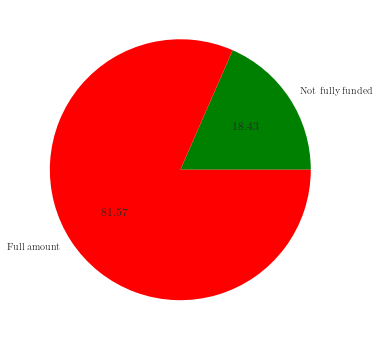

In [6]:
#%matplotlib inline
#import matplotlib.pyplot as plt
import numpy as np
plt.pie(np.c_[np.sum(np.where(y==1,1,0)),np.sum(np.where(y==-1,1,0))][0],
        labels=['Not fully funded','Full amount'],
        colors=['g','r'],
        shadow=False,
        autopct ='%.2f' )
plt.gcf().set_size_inches((6,6))
plt.savefig("pie.png",dpi=300, bbox_inches='tight')


Let us compute the elements of a confusion matrix.

In [7]:
yhat = knn.predict(x)
TP = np.sum(np.logical_and(yhat==-1,y==-1))
TN = np.sum(np.logical_and(yhat==1,y==1))
FP = np.sum(np.logical_and(yhat==-1,y==1))
FN = np.sum(np.logical_and(yhat==1,y==-1))
print('TP: '+ str(TP), ', FP: '+ str(FP))
print('FN: '+ str(FN), ', TN: '+ str(TN))

TP: 3370 , FP: 690
FN: 7 , TN: 73


In [8]:
from sklearn import metrics
metrics.confusion_matrix(yhat,y)

array([[3370,  690],
       [   7,   73]])

In [9]:
#Train a classifier using .fit()
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(x,y)
yhat=knn.predict(x)

print("classification accuracy:", metrics.accuracy_score(yhat, y))
print("confusion matrix: \n" + str(metrics.confusion_matrix(yhat, y)))

classification accuracy: 1.0
confusion matrix: 
[[3377    0]
 [   0  763]]


Up to this point we used training data for "assessing" the performance of the method, as we will see later this is a bad practice. Let us simulate the exploitation stage by holding out a subset of the training data and assess the performance on that set. 

In [10]:
# Simulate a real case: Randomize and split data in two subsets PRC*100% for training and 
# the rest (1-PRC)*100% for testing
import numpy as np
perm = np.random.permutation(y.size)
PRC = 0.7
split_point = int(np.ceil(y.shape[0]*PRC))

X_train = x[perm[:split_point].ravel(),:]
y_train = y[perm[:split_point].ravel()]

X_test = x[perm[split_point:].ravel(),:]
y_test = y[perm[split_point:].ravel()]

print('Training shape: ' + str(X_train.shape), ' , training targets shape: '+str(y_train.shape))
print('Testing shape: ' + str(X_test.shape), ' , testing targets shape: '+str(y_test.shape))

Training shape: (2898, 15)  , training targets shape: (2898,)
Testing shape: (1242, 15)  , testing targets shape: (1242,)


In [11]:
#Train a classifier on training data
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

#Check on the training set and visualize performance
yhat=knn.predict(X_train)

from sklearn import metrics
print("\nTRAINING STATS:")
print("classification accuracy:", metrics.accuracy_score(yhat, y_train))
print("confusion matrix: \n"+ str(metrics.confusion_matrix(y_train, yhat)))


TRAINING STATS:
classification accuracy: 1.0
confusion matrix: 
[[2375    0]
 [   0  523]]


In [12]:
#Check on the test set
yhat=knn.predict(X_test)
print("TESTING STATS:")
print("classification accuracy:", metrics.accuracy_score(yhat, y_test))
print("confusion matrix: \n"+ str(metrics.confusion_matrix(yhat,y_test)))

TESTING STATS:
classification accuracy: 0.749597423510467
confusion matrix: 
[[852 161]
 [150  79]]


We can automatize this process with the tools provided in sklearn.

In [13]:
#The splitting can be done using the tools provided by sklearn:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import metrics

PRC = 0.3
acc = np.zeros((10,))
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=PRC)
    knn = neighbors.KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train,y_train)
    yhat = knn.predict(X_test)
    acc[i] = metrics.accuracy_score(yhat, y_test)
acc.shape=(1,10)
print("Mean expected error: "+str(np.mean(acc[0])))

Mean expected error: 0.7531400966183575


We can use the validation process for model selection.

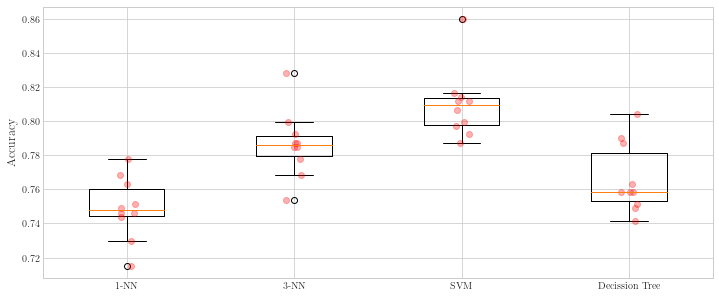

In [14]:
#The splitting can be done using the tools provided by sklearn:
from sklearn import tree
from sklearn import svm

PRC = 0.1
acc_r=np.zeros((10,4))
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=PRC)
    nn1 = neighbors.KNeighborsClassifier(n_neighbors=1)
    nn3 = neighbors.KNeighborsClassifier(n_neighbors=3)
    svc = svm.SVC()
    dt = tree.DecisionTreeClassifier()
    
    nn1.fit(X_train,y_train)
    nn3.fit(X_train,y_train)
    svc.fit(X_train,y_train)
    dt.fit(X_train,y_train)
    
    yhat_nn1=nn1.predict(X_test)
    yhat_nn3=nn3.predict(X_test)
    yhat_svc=svc.predict(X_test)
    yhat_dt=dt.predict(X_test)
    
    acc_r[i][0] = metrics.accuracy_score(yhat_nn1, y_test)
    acc_r[i][1] = metrics.accuracy_score(yhat_nn3, y_test)
    acc_r[i][2] = metrics.accuracy_score(yhat_svc, y_test)
    acc_r[i][3] = metrics.accuracy_score(yhat_dt, y_test)


plt.boxplot(acc_r);
for i in range(4):
    xderiv = (i+1)*np.ones(acc_r[:,i].shape)+(np.random.rand(10,)-0.5)*0.1
    plt.plot(xderiv,acc_r[:,i],'ro',alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(['1-NN','3-NN','SVM','Decission Tree'])
plt.ylabel('Accuracy')
plt.savefig("error_ms_1.png",dpi=300, bbox_inches='tight')

## Learning curves

Let us try to understand the behavior of machine learning algorithms when the amount of data and the "complexity" of the method change. Let us start first by varying the amount of data for a fixed complexity.

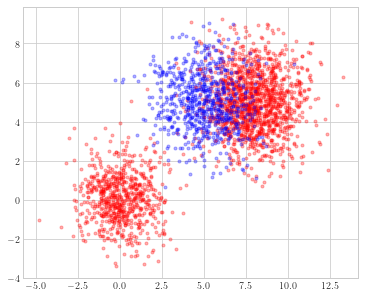

<Figure size 432x288 with 0 Axes>

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
MAXN=700

fig = plt.figure()
fig.set_size_inches(6,5)

plt.plot(1.25*np.random.randn(MAXN,1),1.25*np.random.randn(MAXN,1),'r.',alpha = 0.3)
plt.plot(8+1.5*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2),'r.', alpha = 0.3)
plt.plot(5+1.5*np.random.randn(MAXN,1),5+1.5*np.random.randn(MAXN,1),'b.',alpha = 0.3)
plt.show()
plt.savefig("toy_problem.png",dpi=300, bbox_inches='tight')


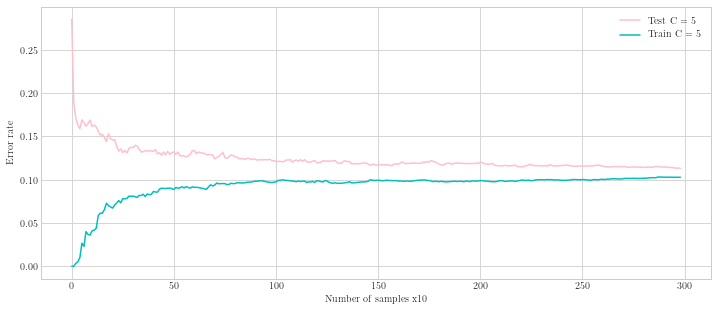

In [16]:
import numpy as np
from sklearn import metrics
from sklearn import tree

C=5
MAXN=1000

yhat_test=np.zeros((10,299,2))
yhat_train=np.zeros((10,299,2))
#Repeat ten times to get smooth curves
for i in range(10):
    X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
    X = np.concatenate([X,[8,5]+1.5*np.random.randn(MAXN,2)])
    y = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
    y = np.concatenate([y,np.ones((MAXN,1))])
    perm = np.random.permutation(y.size)
    X = X[perm,:]
    y = y[perm]

    X_test = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
    X_test = np.concatenate([X_test,[8,5]+1.5*np.random.randn(MAXN,2)])
    y_test = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
    y_test = np.concatenate([y_test,np.ones((MAXN,1))])
    j=0
    for N in range(10,3000,10):
        Xr=X[:N,:]
        yr=y[:N]
        #Evaluate the model
        clf = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=C)
        clf.fit(Xr,yr.ravel())
        yhat_test[i,j,0] = 1. - metrics.accuracy_score(clf.predict(X_test), y_test.ravel())
        yhat_train[i,j,0] = 1. - metrics.accuracy_score(clf.predict(Xr), yr.ravel())
        j=j+1

p1,=plt.plot(np.mean(yhat_test[:,:,0].T,axis=1),'pink')
p2,=plt.plot(np.mean(yhat_train[:,:,0].T,axis=1),'c')
fig = plt.gcf()
fig.set_size_inches(12,5)
plt.xlabel('Number of samples x10')
plt.ylabel('Error rate')
plt.legend([p1,p2],["Test C = 5","Train C = 5"])
plt.savefig("learning_curve_1.png",dpi=300, bbox_inches='tight')

Let us repeat the process with a simpler model.

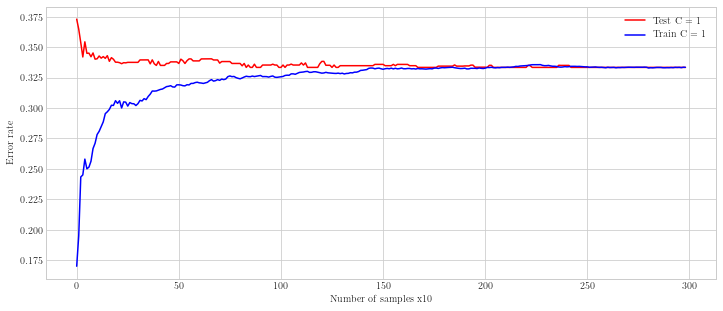

In [17]:
C=1
MAXN=1000

#Repeat ten times to get smooth curves
for i in range(10):
    X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
    X = np.concatenate([X,[8,5]+1.5*np.random.randn(MAXN,2)])
    y = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
    y = np.concatenate([y,np.ones((MAXN,1))])
    perm = np.random.permutation(y.size)
    X = X[perm,:]
    y = y[perm]

    X_test = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
    X_test = np.concatenate([X_test,[8,5]+1.5*np.random.randn(MAXN,2)])
    y_test = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
    y_test = np.concatenate([y_test,np.ones((MAXN,1))])
    j=0
    for N in range(10,3000,10):
        Xr=X[:N,:]
        yr=y[:N]
        #Evaluate the model
        clf = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=C)
        clf.fit(Xr,yr.ravel())
        yhat_test[i,j,1] = 1. - metrics.accuracy_score(clf.predict(X_test), y_test.ravel())
        yhat_train[i,j,1] = 1. - metrics.accuracy_score(clf.predict(Xr), yr.ravel())
        j=j+1

p3,=plt.plot(np.mean(yhat_test[:,:,1].T,axis=1),'r')
p4,=plt.plot(np.mean(yhat_train[:,:,1].T,axis=1),'b')
fig = plt.gcf()
fig.set_size_inches(12,5)
plt.xlabel('Number of samples x10')
plt.ylabel('Error rate')
plt.legend([p3,p4],["Test C = 1","Train C = 1"])
plt.savefig("learning_curve_2.png",dpi=300, bbox_inches='tight')

and join both to see the differences.

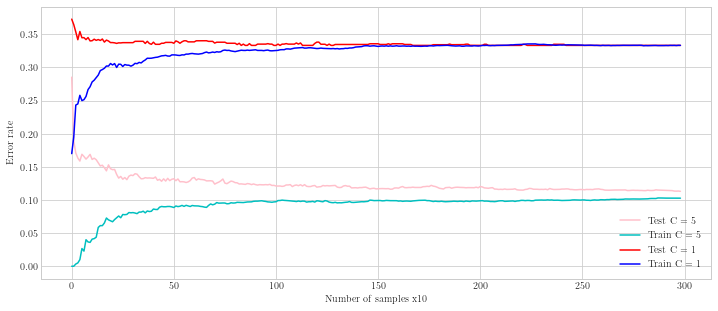

In [18]:
p1,=plt.plot(np.mean(yhat_test[:,:,0].T,axis=1),color='pink')
p2,=plt.plot(np.mean(yhat_train[:,:,0].T,axis=1),'c')
p3,=plt.plot(np.mean(yhat_test[:,:,1].T,axis=1),'r')
p4,=plt.plot(np.mean(yhat_train[:,:,1].T,axis=1),'b')
fig = plt.gcf()
fig.set_size_inches(12,5)
plt.xlabel('Number of samples x10')
plt.ylabel('Error rate')
plt.legend([p1,p2,p3,p4],["Test C = 5","Train C = 5","Test C = 1","Train C = 1"])
fig = plt.gcf()
fig.set_size_inches(12,5)
plt.savefig("learning_curve_3.png",dpi=300, bbox_inches='tight')

Let us check now what happens when we fix the amount of data and change the complexity of the technique.

/Users/santisegui/opt/anaconda3/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


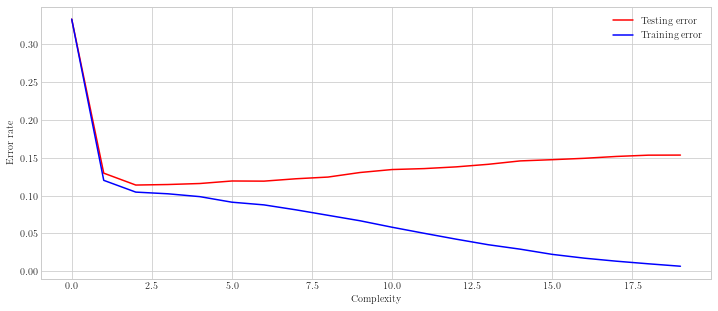

In [19]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.html.widgets import interact
from sklearn import metrics
from sklearn import tree

MAXC=20
N=1000
NTEST=4000
ITERS=3

yhat_test=np.zeros((ITERS,MAXC,2))
yhat_train=np.zeros((ITERS,MAXC,2))
#Repeat ten times to get smooth curves
for i in range(ITERS):
    X = np.concatenate([1.25*np.random.randn(N,2),5+1.5*np.random.randn(N,2)]) 
    X = np.concatenate([X,[8,5]+1.5*np.random.randn(N,2)])
    y = np.concatenate([np.ones((N,1)),-np.ones((N,1))])
    y = np.concatenate([y,np.ones((N,1))])
    perm = np.random.permutation(y.size)
    X = X[perm,:]
    y = y[perm]

    X_test = np.concatenate([1.25*np.random.randn(NTEST,2),5+1.5*np.random.randn(NTEST,2)]) 
    X_test = np.concatenate([X_test,[8,5]+1.5*np.random.randn(NTEST,2)])
    y_test = np.concatenate([np.ones((NTEST,1)),-np.ones((NTEST,1))])
    y_test = np.concatenate([y_test,np.ones((NTEST,1))])

    j=0
    for C in range(1,MAXC+1):
        #Evaluate the model
        clf = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=C)
        clf.fit(X,y.ravel())
        yhat_test[i,j,0] = 1. - metrics.accuracy_score(clf.predict(X_test), y_test.ravel())
        yhat_train[i,j,0] = 1. - metrics.accuracy_score(clf.predict(X), y.ravel())
        j=j+1

p1, = plt.plot(np.mean(yhat_test[:,:,0].T,axis=1),'r')
p2, = plt.plot(np.mean(yhat_train[:,:,0].T,axis=1),'b')
fig = plt.gcf()
fig.set_size_inches(12,5)
plt.xlabel('Complexity')
plt.ylabel('Error rate')
plt.legend([p1, p2], ["Testing error", "Training error"])
plt.savefig("learning_curve_4.png",dpi=300, bbox_inches='tight')

We may use all these concepts to understand and select the complexity of a model.

Mean accuracy: [0.82536232 0.8263285  0.83188406 0.83429952 0.8352657  0.8326087
 0.82971014 0.82560386 0.82198068 0.81956522 0.81256039 0.81086957
 0.80483092 0.80169082 0.80072464 0.78599034 0.77995169 0.78091787]
Selected model index: 4
Complexity: 6


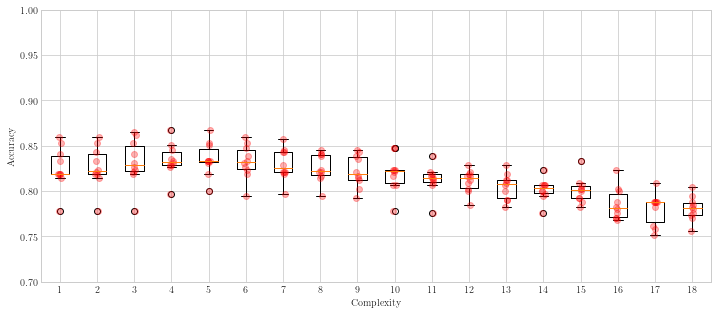

In [20]:
%reset -f
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import KFold
import pickle

ofname = open('files/ch05/dataset_small.pkl','rb') 
(X,y) = pickle.load(ofname, encoding="latin1")

#Create a 10-fold cross validation set
kf = KFold(n_splits=10, shuffle=True, random_state=0)
      
#Search the parameter among the following
C=np.arange(2,20,)

acc = np.zeros((10,18))
i=0
for train_index, val_index in kf.split(y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    j=0
    for c in C:
        dt = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=c)
        dt.fit(X_train,y_train)
        yhat = dt.predict(X_val)
        acc[i][j] = metrics.accuracy_score(yhat, y_val)
        j=j+1
    i=i+1
    
plt.boxplot(acc);
for i in range(18):
    xderiv = (i+1)*np.ones(acc[:,i].shape)+(np.random.rand(10,)-0.5)*0.1
    plt.plot(xderiv,acc[:,i],'ro',alpha=0.3)

print('Mean accuracy: ' + str(np.mean(acc,axis = 0)))
print('Selected model index: ' + str(np.argmax(np.mean(acc,axis = 0))))
print('Complexity: ' + str(C[np.argmax(np.mean(acc,axis = 0))]))
plt.ylim((0.7,1.))
fig = plt.gcf()
fig.set_size_inches(12,5)
plt.xlabel('Complexity')
plt.ylabel('Accuracy')
plt.savefig("model_selection.png",dpi=300, bbox_inches='tight')

Mean accuracy: [0.8254832  0.83031158 0.83091854 0.83423816 0.8339406  0.83243002
 0.82759892 0.820653   0.81883577 0.818237   0.80887144 0.80373822
 0.79891166 0.79528628 0.79559113 0.78230262 0.7841144  0.78351199]
Selected model index: 3
Complexity: 5
Test accuracy: 0.8260869565217391


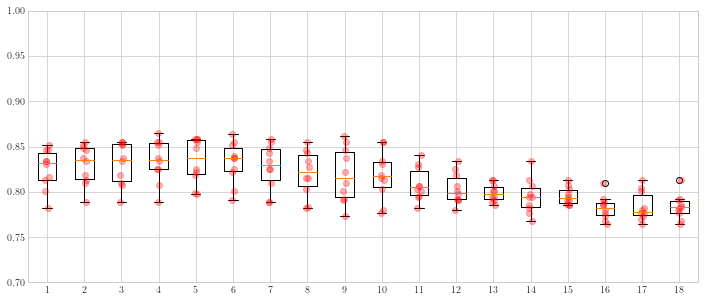

In [21]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import pickle

ofname = open('files/ch05/dataset_small.pkl','rb') 
(X,y) = pickle.load(ofname, encoding='latin1')

#Train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#Create a 10-fold cross validation set
kf=KFold( n_splits=10, shuffle=True, random_state=0)     
#Search the parameter among the following
C=np.arange(2,20,)
acc = np.zeros((10,18))
i=0
for train_index, val_index in kf.split(X_train):
    X_t, X_val = X_train[train_index], X_train[val_index]
    y_t, y_val = y_train[train_index], y_train[val_index]
    j=0
    for c in C:
        dt = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=c)
        dt.fit(X_t,y_t)
        yhat = dt.predict(X_val)
        acc[i][j] = metrics.accuracy_score(yhat, y_val)
        j=j+1
    i=i+1

print('Mean accuracy: ' + str(np.mean(acc,axis = 0)))
print('Selected model index: ' + str(np.argmax(np.mean(acc,axis = 0))))
print('Complexity: ' + str(C[np.argmax(np.mean(acc,axis = 0))]))


#Train the model with the complete training set with the selected complexity
dt = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=C[np.argmax(np.mean(acc,axis = 0))])
dt.fit(X_train,y_train)
#Test the model with the test set 
yhat = dt.predict(X_test)
print('Test accuracy: ' + str(metrics.accuracy_score(yhat, y_test)))

#Train the model for handling to the client
dt = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=C[np.argmax(np.mean(acc,axis = 0))])
dt.fit(X,y)

plt.boxplot(acc);
for i in range(18):
    xderiv = (i+1)*np.ones(acc[:,i].shape)+(np.random.rand(10,)-0.5)*0.1
    plt.plot(xderiv,acc[:,i],'ro',alpha=0.3)


plt.ylim((0.7,1.))
fig = plt.gcf()
fig.set_size_inches(12,5)

WARNING: The following cell takes a long time to execute.

In [22]:
%reset -f
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import linear_model
from sklearn.model_selection import KFold,GridSearchCV
from sklearn import metrics

import pickle
ofname = open('files/ch05/dataset_small.pkl','rb') 
(X,y) = pickle.load(ofname, encoding='latin1')

parameters = {'C':[1e4,1e5,1e6],'gamma':[1e-5,1e-4,1e-3]}

N_folds = 5

kf=KFold( n_splits=N_folds,  shuffle=True, random_state=0)

acc = np.zeros((N_folds,))
i=0
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    clf = svm.SVC(kernel='rbf')
    clf = GridSearchCV(clf, parameters, cv = 3) #This line does a cross-validation on the 
    clf.fit(X_train,y_train.ravel())
    X_test = scaler.transform(X_test)
    yhat[test_index] = clf.predict(X_test)
    
print(metrics.accuracy_score(yhat, y))
print(metrics.confusion_matrix(yhat, y))

0.856280193236715
[[3372  590]
 [   5  173]]


WARNING: The following cell takes a long time to execute.

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import KFold,GridSearchCV
from sklearn import metrics

dvals = [{1:0.25},{1:0.5},{1:1},{1:2},{1:4},{1:8},{1:16}]
opoint = []

for cw in dvals:

    parameters = {'C':[1e4,1e5,1e6],'gamma':[1e-5,1e-4,1e-3],'class_weight':[cw]}
  
    print(parameters)

    N_folds = 5

    kf=KFold(n_splits=N_folds,  shuffle=True, random_state=0)

    acc = np.zeros((N_folds,))
    mat = np.zeros((2,2,N_folds))
    i=0
    yhat = y.copy()
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        clf = svm.SVC(kernel='rbf')
        clf = GridSearchCV(clf, parameters, cv = 3)
        clf.fit(X_train,y_train.ravel())
        X_test = scaler.transform(X_test)
        yhat[test_index] = clf.predict(X_test)
        acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
        mat[:,:,i] = metrics.confusion_matrix(yhat[test_index], y_test)
        print(str(clf.best_params_))
        i=i+1
    print('Mean accuracy: '+ str(np.mean(acc)))
    opoint.append((np.mean(acc),np.sum(mat,axis=2)))


{'C': [10000.0, 100000.0, 1000000.0], 'gamma': [1e-05, 0.0001, 0.001], 'class_weight': [{1: 0.25}]}
{'C': 100000.0, 'class_weight': {1: 0.25}, 'gamma': 0.001}
{'C': 100000.0, 'class_weight': {1: 0.25}, 'gamma': 0.001}
{'C': 100000.0, 'class_weight': {1: 0.25}, 'gamma': 0.001}
{'C': 100000.0, 'class_weight': {1: 0.25}, 'gamma': 0.001}
{'C': 100000.0, 'class_weight': {1: 0.25}, 'gamma': 0.001}
Mean accuracy: 0.8555555555555555
{'C': [10000.0, 100000.0, 1000000.0], 'gamma': [1e-05, 0.0001, 0.001], 'class_weight': [{1: 0.5}]}
{'C': 100000.0, 'class_weight': {1: 0.5}, 'gamma': 0.001}
{'C': 1000000.0, 'class_weight': {1: 0.5}, 'gamma': 0.0001}
{'C': 1000000.0, 'class_weight': {1: 0.5}, 'gamma': 0.0001}
{'C': 1000000.0, 'class_weight': {1: 0.5}, 'gamma': 0.0001}
{'C': 1000000.0, 'class_weight': {1: 0.5}, 'gamma': 0.0001}
Mean accuracy: 0.8557971014492753
{'C': [10000.0, 100000.0, 1000000.0], 'gamma': [1e-05, 0.0001, 0.001], 'class_weight': [{1: 1}]}
{'C': 10000.0, 'class_weight': {1: 1}, 'gam

In [ ]:
%reset -f
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn import metrics
import numpy as np

import pickle
ofname = open('files/ch05/dataset_small.pkl','rb') 
(X,y) = pickle.load(ofname, encoding = 'latin1')

dvals = [{1:0.25},{1:0.5},{1:1},{1:2},{1:4},{1:8},{1:16}]

kf=KFold(n_folds=5, shuffle=True, random_state=0)

acc = np.zeros((5,))
i=0
yhat = y.copy()
for cw in dvals:
    i=0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        dt = ensemble.RandomForestClassifier(n_estimators=51, class_weight=cw)
        dt.fit(X_train,y_train)
        yhat[test_index]=dt.predict(X_test)
        acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
        i=i+1
    #Run here the code from the next cell for checking each of the performance plots

In [ ]:
#You may run this code for each iteration in the former cell to get the surface pltos.
#The prediction of a configuration is given in yhat

M=metrics.confusion_matrix(yhat, y)

from matplotlib import cm
ccampaing = [10,20,30,40,50,60,70,80,90]
retention = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
TP=M[0,0]
FN=M[1,0]
FP=M[0,1]
TN=M[1,1]
campaing=TN+FN
profit=TP+FN

[xx,yy]=np.meshgrid(ccampaing,retention)
cost = 100*profit-xx*campaing + yy*TN*100

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111, projection='3d')
cost_no_campaign = 100*profit+0*xx
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

Z = np.where(cost>cost_no_campaign,cost,cost_no_campaign)
ax.plot_surface(xx,yy,Z,cmap=cm.coolwarm,alpha=0.3,linewidth=0.1,rstride=1,cstride=1)
ax.plot_wireframe(xx, yy, Z, rstride=1, cstride=1, color=[0.5,0.5,0.5],alpha=0.5)
fig.set_size_inches((12,8))
ax.set_xlabel('campaign cost',size=16)
ax.set_ylabel('retention rate',size=16)
ax.set_zlabel('profit',size=16)
fig.savefig('rf_cost.png',dpi=100,format='PNG')

print('Max profit: ' + str(100*(np.max(Z)-np.min(Z))/np.min(Z)))
print('Max profit for retention rate: '  + str(100*(np.max(Z[5])-np.min(Z))/np.min(Z)))
print('Campaign cost:')
print('Accuracy: ' + str((TP+TN)/(TP+FN+FP+FN*1.)))
print('Confusion: ' + str(M))